# Neural Network Convolutional Decoder

Julien Doe

## *** WORK IN PROGRESS ***

## Background

In the effort to develop a neural network turbo decoder, we will start by looking at a neural network convolutional decoder. The goal is to develop a decoder implementation which rivals the BER performance of a maximum a posteriori (MAP) decoder.

## Imports

In [1187]:
# Common
import os
import numpy as np
import scipy as sp
import pandas as pd

# DSP
from math import log10

# Neural Network
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import Model
from keras.layers import Input, Dense, LSTM, Add, Dropout, Lambda, Concatenate
from keras.models import clone_model
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt

## Reusable Code

### Helper Functions

In [1188]:
# Calculate RMS of a signal
def rms(x):
    return np.sqrt(np.mean(np.array(x).real**2)) # Assume symmetric loading for complex data

In [1189]:
# Convert binary array to decimal value
def bin2dec(binary):
    binary = np.array(binary, dtype = bool)
    return np.sum([val * 2**index for index, val in zip(range(len(binary)-1 , -1, -1), binary)]).astype(int)

# Convert decimal value to binary array
def dec2bin(dec, nbits):
    str = bin(dec)[2:].zfill(nbits)
    return np.array([bit == '1' for bit in list(str)], dtype = int)

In [1190]:
# Distance between two complex points
def complex_distance(x1, x2):
    return np.linalg.norm(np.array([x1.real, x1.imag]) - np.array([x2.real, x2.imag]))

In [1191]:
# Convert symbol error rate to noise standard deviation for constellation
def error2sd(error_rate, constellation):
    # Find all distances between constellation points
    distances = []
    for i, sym1 in enumerate(constellation[:-1]):
        distances += [complex_distance(sym1, sym2) for sym2 in constellation[i+1:]]

    # Find minimum distance as threshold for a symbol error
    min_dist = np.min(distances) / 2 # Divide by 2 since boundary is halfway between

    # Use PPF (effectively inverse of CDF) to derive threshold for noise
    error_thresh = 1 - (error_rate / 2) # Convert error rate to upper range on PDF x-axis
    noise_thresh = sp.stats.norm.ppf(error_thresh, loc=0, scale=1/min_dist)

    # Calculate standard deviation
    noise_sd = 1 / noise_thresh

    # Back-calculate error rate to double check
    back_prob = sp.stats.norm.cdf(min_dist, loc=0, scale=noise_sd)
    back_rate = 2 * (1 - back_prob)

    # Return standard deviation
    return noise_sd

### Training Callback Functions

In [1192]:
# Early stopping
def get_early_stopping(patience = 5):
    return keras.callbacks.EarlyStopping(
        monitor='loss',
        mode='min',
        patience=patience, 
        restore_best_weights=True, 
        start_from_epoch=0)

# Reduce learning rate when a plateau is hit
def get_lr_plateau(patience = 3):
    return keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        mode='min',
        factor=0.1,
        patience=patience)

## Encoders

We will utilize the encoders listed in the convolutional encoder Wikipedia page: https://en.wikipedia.org/wiki/Convolutional_code



### Two State

From Wikipedia page, Figure 3:

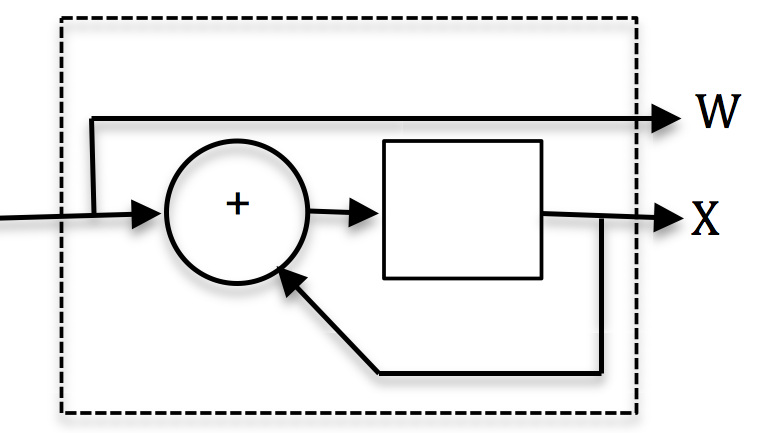


In [1193]:
def encode2(data):
    # Cast input to Boolean
    data = np.array(data).astype(bool)

    # Initialize
    state = np.zeros(1, dtype=bool)
    code = np.zeros((2*len(data)), dtype=bool)

    # Iterate
    for i in range(0, len(code), 2):
        # Set systematic output
        systematic = data[np.floor(i/2).astype(int)]
        code[i] = systematic

        # Set parity output
        code[i+1] = state

        # Update state
        state = np.logical_xor(code[i], state)

    # Return
    return code.astype(int)

### Four State

From Wikipedia page, Figure 4:

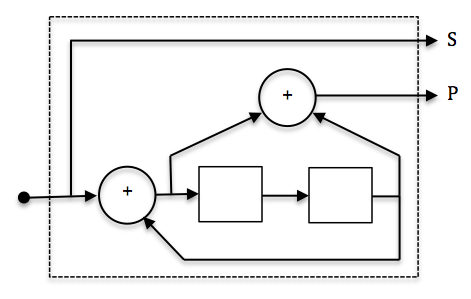



In [1194]:
def encode4(data):
    # Cast input to Boolean
    data = np.array(data).astype(bool)

    # Initialize
    state = np.zeros(2, dtype=bool)
    code = np.zeros(2*len(data), dtype=bool)

    # Iterate
    for i in range(0, len(code), 2):
        # Set systematic output
        systematic = data[np.floor(i/2).astype(int)]
        code[i] = systematic

        # Set parity output
        temp = np.logical_xor(state[1], systematic)
        code[i+1] = np.logical_xor(state[1], temp)

        # Update state
        state[1:-1] = state[0:-2]
        state[0] = temp

    # Return
    return code.astype(int)

### Sixteen State

From Wikipedia page, Figure 5:

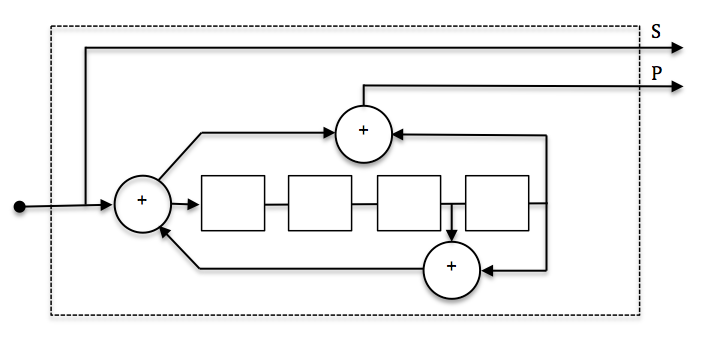

In [1195]:
def encode16(data):
    # Cast input to Boolean
    data = np.array(data).astype(bool)

    # Initialize
    state = np.zeros(4, dtype=bool)
    code = np.zeros(2*len(data), dtype=bool)

    # Iterate
    for i in range(0, len(code), 2):
        # Set systematic output
        systematic = data[np.floor(i/2).astype(int)]
        code[i] = systematic

        # Set parity output
        temp1 = np.logical_xor(state[2], state[3])
        temp2 = np.logical_xor(temp1, systematic)
        code[i+1] = np.logical_xor(state[3], temp2)

        # Update state
        state[1:-1] = state[0:-2]
        state[0] = temp2

    # Return
    return code.astype(int)

## Link

For now we only work with the simplest case of adding white Gaussian noise to the symbols. We don't model
- Pulse shaping and matched filtering
- Upconversion and carrier recovery

These are deemed unnecessary to develop a working decoder, but can be added in later to use a more complete link model.


### Constants

In [1196]:
# Modulation
BITS_PER_SYMBOL = 2 # QPSK
NUM_SYMBOLS = 2**BITS_PER_SYMBOL
GREY_CODES = np.array(range(NUM_SYMBOLS), dtype=int)
CONSTELLATION = np.exp(1j * np.pi * np.array(range(1, 2*NUM_SYMBOLS, 2)) / NUM_SYMBOLS)

### Functions

In [1197]:
# Take in a vector of bits and convert to symbols
def modulate(bits, constellation, bps=None):
    # Resolve bits per symbol
    if bps is None:
        bps = np.ceil(np.log2(len(constellation))).astype(int)

    # Format for mapping
    bits = bits.reshape((-1,bps))
        
    # Map to symbols
    codes = np.array([bin2dec(chunk) for chunk in bits])
    symbols = np.array([constellation[code] for code in codes])

    # Return
    return symbols

In [1198]:
# Add channel distortions to symbols
def channel(tx, bps, ebno=None, snr=None, sps=1):
    # Resolve inputs
    if snr is None:
        if ebno is None:
            # If neither given, return tx as is
            return tx
        else:
            # Otherwise derive SNR = Eb / N0 + 10log10((Nbps×R) / Nsps)
            # https://www.mathworks.com/help/comm/ref/convertsnr.html
            snr = ebno + 10*np.log10(bps * 0.5 / sps)

    # Cast input to numpy array
    tx = np.array(tx)

    # Determine added noise power
    PsignalDB = 10*log10(rms(tx)**2)
    PnoiseDB = PsignalDB - snr
    
    # Generate noise
    nsamples = len(tx)
    sd = 10**(PnoiseDB / 20)
    if np.any(np.iscomplex(tx)):
        awgn = np.random.normal(0, sd, nsamples) + 1j*np.random.normal(0, sd, nsamples)
    else:
        awgn = np.random.normal(0, sd, nsamples)

    # Add to signal
    rx = tx + awgn

    # Return
    return rx

In [1199]:
def demodulate(rx):
    # Just a passthrough
    return rx

In [1236]:
def llr(symbols):
    # Derive indices for probability
    indices = np.array([dec2bin(code, BITS_PER_SYMBOL) for code in GREY_CODES]).astype(bool)

    # Initialize output
    llrs = np.zeros((symbols.shape[0], BITS_PER_SYMBOL))

    # Iterate over symbols
    for s, symbol in enumerate(symbols):
        # Get set of all Euclidean distances
        diffs = np.array(symbol - CONSTELLATION).reshape((-1,1))
        distances = np.linalg.norm(diffs, axis=1)
        with np.errstate(divide='ignore'): # Ignores divide by zero warning since it will often happen here
            likelihoods = np.array(1) / distances

        # Iterate and calculate LLRs
        for b in range(BITS_PER_SYMBOL):
            # LLR is P(1) / P(0)
            idx0 = ~indices[:,b]
            idx1 = indices[:,b]
            temp = np.log(np.sum(likelihoods[idx1])) - np.log(np.sum(likelihoods[idx0]))
            llrs[s, b] = temp

    # Sigmoid function to map to [-1, 1]
    #llrs = 1 / (1 + np.exp(-1 * llrs))
    llrs = np.arctan(llrs)

    # Return
    return llrs


## Data

With our encoder and link defined, we can generate our data set.

One important note is that our model isn't going to output the recovered data (pre encoder), it is going to output the corrected codeword (post encoder). Specifically, it is going to output the corrected LLRs. This is done for two reasons:

1. It is possible to do multiiple iterations of decoding, as is done in Turbo decoding. Thus we want the output to be effectively the same type of data as the input (albiet corrected) so that it can be plugged back in. Outputting the original data limits it to one iteration
2. It is a trivial operation to make a decision on the bits at any point and recover the original data.

Helper Functions

In [1238]:
# Function for generating data at various SNRs
def generate_symbols(snr):
    # Data words
    lengths = np.random.randint(low=MIN_LENGTH, high=MAX_LENGTH+1, size=NUM_EXAMPLES)
    datawords = [np.random.choice([True, False], size=length) for length in lengths]

    # Code words
    codewords = [ENCODER(data) for data in datawords]

    # Complex symbols
    tx = np.array([modulate(codeword, CONSTELLATION) for codeword in codewords])

    # Channel
    rx = np.array([demodulate(channel(example, BITS_PER_SYMBOL, snr=snr)) for example in tx])
    
    return tx, rx

# Convert to LLRs and split
def prepare_for_training(tx, rx, split=0.3):
    # Convert to LLRs
    x = np.array([llr(example) for example in rx])
    y = np.array([llr(example) for example in tx])

    # Split
    return train_test_split(x, y, test_size = split)


# Plot LLRs
def plot_llrs(tx, rx):
    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Format axes
    ax[0].plot(tx)
    ax[0].grid()
    ax[0].set_title('Tx')
    ax[0].set_xlabel('n')
    ax[0].set_ylabel('LLR[n]')

    # Plot Rx
    ax[1].plot(rx)
    ax[1].grid()
    ax[1].set_title('Rx')
    ax[1].set_xlabel('n')
    ax[1].set_ylabel('LLR[n]')

    plt.tight_layout()


# Plot symbols
def plot_symbols(tx, rx):
    # Get Gray codes
    const = list(CONSTELLATION)
    codes = [const.index(symbol) for symbol in tx]

    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot data
    for i in range(NUM_SYMBOLS):
        indices = [code == i for code in codes]
        ax[0].plot(tx[indices].real, tx[indices].imag, '.')
        ax[1].plot(rx[indices].real, rx[indices].imag, '.')

    # Format axes
    ax[0].grid()
    ax[0].set_title('Tx')
    ax[0].set_xlabel('I')
    ax[0].set_ylabel('Q')

    # Plot Rx
    ax[1].grid()
    ax[1].set_title('Rx')
    ax[1].set_xlabel('I')
    ax[1].set_ylabel('Q')

    plt.tight_layout()


# Check number of errors between x and y
def check_errors(x, y):
    # Get signs
    x_signs = np.sign(x)
    y_signs = np.sign(y)

    # Compare
    compare = np.not_equal(x_signs, y_signs)
    errors = np.sum(compare)
    return errors


Constants

In [1243]:
# Message
MIN_LENGTH = 100
MAX_LENGTH = 100
NUM_EXAMPLES = 1000

# Encoder
ENCODER = encode2

# SNR
ERROR_RATE = 0.1
SD = error2sd(ERROR_RATE, CONSTELLATION)
SNR = 10*log10(1/ SD**2)

In [1244]:
tx, rx = generate_symbols(SNR)
x_train, x_test, y_train, y_test = prepare_for_training(tx, rx)

5 errors before decoding


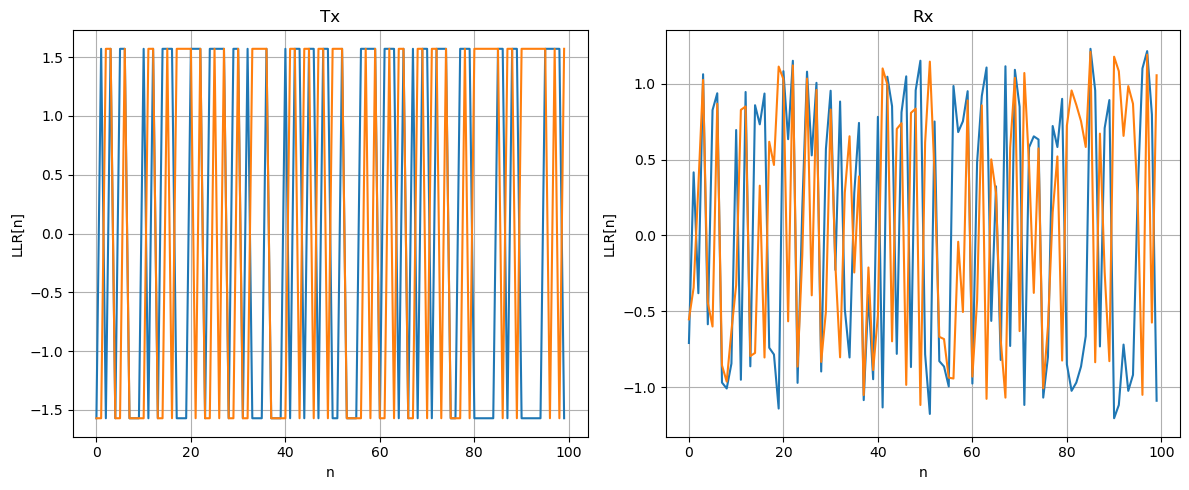

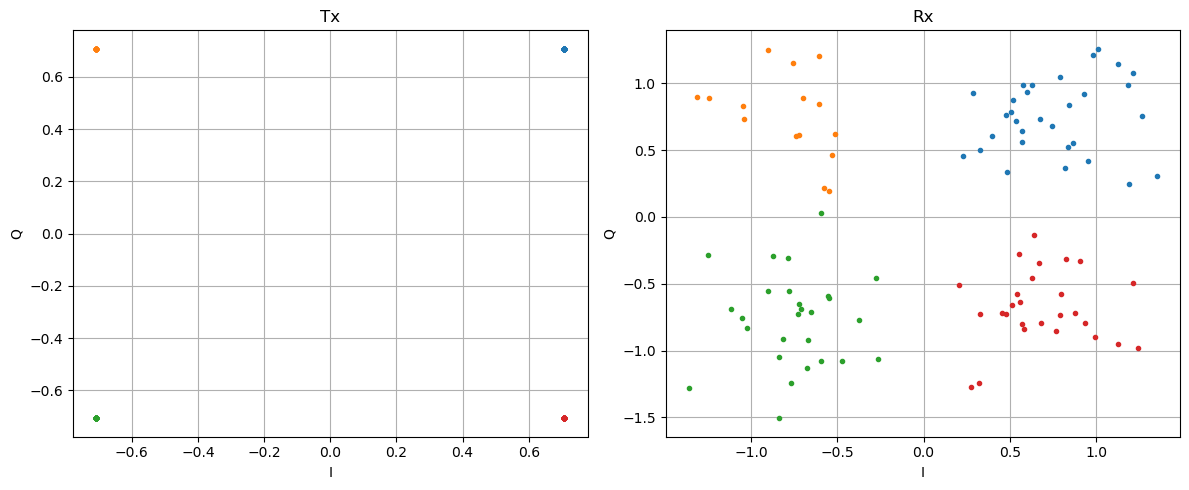

In [1248]:
index = 2
print(f'{check_errors(x_train[index], y_train[index])} errors before decoding')
plot_llrs(y_train[index], x_train[index])
plot_symbols(tx[index], rx[index])

## Models

This model will be set up as a sequence-to-sequence (seq2seq) LSTM model

### Common Layer Setup

In [1214]:
# Model Parameters
NUM_DENSE_HIDDEN = 16
NUM_LSTM = 8

# Input
common_input_shape = (None, BITS_PER_SYMBOL)
common_input = Input(shape = common_input_shape, name = 'input', dtype=tf.complex128)

# Dense Hidden Layer
common_dense = Dense(NUM_DENSE_HIDDEN,
    name = 'hidden',
    activation = 'relu',
    use_bias = True, # Allow bias
    kernel_initializer = 'glorot_uniform', # Standard initializer
    kernel_regularizer = None, # Small dropout
    dtype = 'float32')

# LSTM Layer
common_lstm = LSTM(NUM_LSTM,
    name = 'lstm', 
    activation = 'tanh',
    recurrent_activation = 'sigmoid',
    use_bias = True,
    kernel_initializer = 'glorot_uniform', 
    recurrent_initializer = 'orthogonal',
    kernel_regularizer = None,
    recurrent_regularizer = None, 
    return_sequences=True,
    return_state=False,
    use_cudnn=False)

# Output Layer
common_output = Dense(BITS_PER_SYMBOL, # Want one output per symbol bit
    name = 'output',
    activation = 'tanh', # Maps to -1 < x < 1
    use_bias = True, # Allow bias
    kernel_initializer = 'glorot_uniform', # Standard initializer
    kernel_regularizer = None, # No regularizer
    dtype = 'float32')


### Simple Dense

In [1215]:
# Build Model
input = Input(shape = common_input_shape, name = 'input')
hidden = clone_model(common_dense)(input)
output = clone_model(common_output)(hidden)
simple = Model(inputs = input, outputs = output, name='simple_dense')
# simple.get_layer('llr').trainable = False

# Compile
simple.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.RMSprop(0.1), 
        metrics=['mean_absolute_error'])

# Summarize
simple.summary()

Model: "simple_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, None, 16)       │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, None, 2)        │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82 (328.00 B)

 Trainable params: 82 (328.00 B)

 Non-trainable params: 0 (0.00 B)

In [1216]:
history = simple.fit(
    x_train,
    y_train, 
    shuffle=True,
    batch_size=1, 
    epochs=3, 
    verbose=1)

Epoch 1/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - loss: 0.1077 - mean_absolute_error: 0.1077
Epoch 2/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 0.0329 - mean_absolute_error: 0.0329
Epoch 3/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 0.0348 - mean_absolute_error: 0.0348


### Single LSTM

In [1217]:
# Build Model
input = Input(shape = common_input_shape, name = 'input')
lstm = clone_model(common_lstm)(input)
output = clone_model(common_output)(lstm)
single = Model(inputs = input, outputs = output, name='single_lstm')
# simple.get_layer('llr').trainable = False

# Compile
single.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.RMSprop(0.1), 
        metrics=['mean_absolute_error'])

# Summarize
single.summary()

Model: "single_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 8)        │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, None, 2)        │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 370 (1.45 KB)

 Trainable params: 370 (1.45 KB)

 Non-trainable params: 0 (0.00 B)

In [1218]:
history = single.fit(
    x_train,
    y_train, 
    shuffle=True,
    batch_size=1, 
    epochs=3, 
    verbose=1)

Epoch 1/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1347 - mean_absolute_error: 0.1347
Epoch 2/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0276 - mean_absolute_error: 0.0276
Epoch 3/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0271 - mean_absolute_error: 0.0271


### Single LSTM with Residual Connection

In [1091]:
# Build Model
input = Input(shape = common_input_shape, name = 'input')
lstm = clone_model(common_lstm)(input)
dense = clone_model(common_output)(lstm)
output = Add()([dense, input])
residual = Model(inputs = input, outputs = output, name='single_lstm_residual')

# Compile
residual.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.RMSprop(0.1), 
        metrics=['mean_absolute_error'])

# Summarize
residual.summary()

Model: "single_lstm_residual"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, None, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, None, 8)   │        352 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, None, 2)   │         18 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, None, 2)   │          0 │ output[0][0],     │
│                     │                   │            │ input[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 370 (1.45 KB)

 Trainable params: 370 (1.45 KB)

 Non-trainable params: 0 (0.00 B)

In [1092]:
history = residual.fit(
    x_train,
    y_train, 
    shuffle=True,
    batch_size=1, 
    epochs=3, 
    verbose=1)

Epoch 1/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1809 - mean_absolute_error: 0.1809
Epoch 2/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1524 - mean_absolute_error: 0.1524
Epoch 3/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1468 - mean_absolute_error: 0.1468


### Multilayer LSTM

In [192]:
# Build Model
input = Input(shape = common_input_shape, name = 'input')

temp = clone_model(common_lstm)
temp._name = 'lstm1'
lstm1 = temp(input)

temp = clone_model(common_lstm)
temp.name = 'lstm2'
lstm2 = temp(lstm1)

output = clone_model(common_output)(lstm2)
multi = Model(inputs = input, outputs = output, name='multi_lstm')

# Compile
multi.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.Adam(0.1), 
        metrics=['mean_absolute_error'])

# Summarize
multi.summary()

Model: "multi_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 8)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ (None, None, 8)        │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, None, 1)        │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 873 (3.41 KB)

 Trainable params: 873 (3.41 KB)

 Non-trainable params: 0 (0.00 B)

### Multilayer LSTM with Residual Connection

Residual connection to the end

In [193]:
# Build Model
input = Input(shape = common_input_shape, name = 'input')

temp = clone_model(common_lstm)
temp._name = 'lstm1'
lstm1 = temp(input)

temp = clone_model(common_lstm)
temp.name = 'lstm2'
lstm2 = temp(lstm1)

dense = clone_model(common_output)(lstm2)
output = Add()([dense, input])

multi_res = Model(inputs = input, outputs = output, name='multi_lstm')

# Compile
multi_res.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.Adam(0.1), 
        metrics=['mean_absolute_error'])

# Summarize
multi_res.summary()

Model: "multi_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, None, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, None, 8)   │        320 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm2 (LSTM)        │ (None, None, 8)   │        544 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, None, 1)   │          9 │ lstm2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 1)   │          0 │ output[0][0],     │
│                     │                   │            │ input[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 873 (3.41 KB)

 Trainable params: 873 (3.41 KB)

 Non-trainable params: 0 (0.00 B)

### Transformer

Encoder/Decoder structure

# Archive

## LLRs

Here we make a model for the LLR generator. It consists of two layers:

1. Symbol Activation
2. LLR Mapping

Since we know the structure we want, we will take out the guess work and train each layer individually

### Training Data

In [ ]:
# Constants
LLR_NUM_SAMPLES = 10000
LLR_ERROR_RATE = 0.1
LLR_SD = error2sd(LLR_ERROR_RATE, CONSTELLATION)
LLR_TEST_SYMBOLS = np.exp(1j * np.pi * np.array(range(1, 2*2*NUM_SYMBOLS, 2)) / 2*NUM_SYMBOLS)

# Grey codes
codes = np.random.randint(low=0, high=NUM_SYMBOLS, size=LLR_NUM_SAMPLES)

# Corresponding symbols (LLR input)
symbols = np.array([CONSTELLATION[code] for code in codes])
symbols += np.random.normal(0, LLR_SD, LLR_NUM_SAMPLES) + 1j*np.random.normal(0, LLR_SD, LLR_NUM_SAMPLES)

# One-hot Grey codes (first LLR layer output)
onehot = 2*keras.utils.to_categorical(codes, num_classes=NUM_SYMBOLS)-1

# Bits, mapped to +/-1 (second LLR layer output)
bits = 2*np.array([dec2bin(code, BITS_PER_SYMBOL) for code in codes])-1

### First Layer: Symbol Activation

This layer contains one unit for each symbol in the constellation. It takes in the complex symbol values and creates activations for each symbol; similar to a one-hot encoding

In [ ]:
# Make layer which converts complex symbols to one hot "activations"
input = Input(shape = (1,), dtype = tf.complex128, name = 'input')
real = Lambda(tf.math.real)(input)
imag = Lambda(tf.math.imag)(input)
concat = Concatenate(axis=-1)([real, imag])
hidden = Dense(NUM_SYMBOLS, # One unit per symbol
    name = 'hidden',
    activation = 'tanh', # Maps to -1 < x < 1
    use_bias = True, # Allow bias
    kernel_initializer = 'glorot_uniform', # Standard initializer
    kernel_regularizer = None, # Small dropout
    dtype = 'float32')(concat)
llr = Model(inputs = input, outputs = hidden, name='llr_onehot')

llr.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.RMSprop(0.1), 
        metrics=['mean_absolute_error'])

# Train
x_train_llr, x_test_llr, y_train_llr, y_test_llr = train_test_split(symbols, onehot, test_size = 0.3)
history = llr.fit(
    x_train_llr,
    y_train_llr, 
    shuffle=True,
    batch_size=10, 
    epochs=10, 
    verbose=0)


for x in LLR_TEST_SYMBOLS:
    print(f'Output {llr(np.expand_dims(x, axis=0))}')

Output [[ 0.98317784 -1.         -1.          0.51336724]]
Output [[ 0.98317784 -1.         -1.          0.51336724]]
Output [[ 0.98317784 -1.         -1.          0.51336724]]
Output [[ 0.98317784 -1.         -1.          0.51336724]]
Output [[ 0.98317784 -1.         -1.          0.51336724]]
Output [[ 0.98317784 -1.         -1.          0.51336724]]
Output [[ 0.98317784 -1.         -1.          0.51336724]]
Output [[ 0.98317784 -1.         -1.          0.51336724]]


### Second Layer: LLR Mapping

This layer takes the symbol activations from the previous layer and converts them to the equivalent bit LLRs. This is effectively converting them to the underlying bits, except mapped to +/-1 instead of 0/1.

In [ ]:
# Add layer which converts symbol activations to LLRs
output = Dense(BITS_PER_SYMBOL, # Want one output per symbol bit
    name = 'output',
    activation = 'tanh', # Maps to -1 < x < 1
    use_bias = True, # Allow bias
    kernel_initializer = 'glorot_uniform', # Standard initializer
    kernel_regularizer = None, # No regularizer
    dtype = 'float32')(hidden)
llr = Model(inputs = input, outputs = output, name='llr')
llr.get_layer('hidden').trainable = False # Turn off training for first layer

llr.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.RMSprop(0.1), 
        metrics=['mean_absolute_error'])

# Train
x_train_llr, x_test_llr, y_train_llr, y_test_llr = train_test_split(symbols, bits, test_size = 0.3)

history = llr.fit(
    x_train_llr,
    y_train_llr, 
    shuffle=True,
    batch_size=10, 
    epochs=10, 
    verbose=0)

for x in LLR_TEST_SYMBOLS:
    print(f'Output {llr(np.expand_dims(x, axis=0))}')

Output [[-0.9999998 -0.9999998]]
Output [[-0.9999998  0.9999998]]
Output [[ 0.9999998 -0.9999998]]
Output [[0.9999998 0.9999998]]
